# workflows presented in "The long-term instability of glacier dynamics due to a sudden change of basal lubrication"

## (DRAFT) v 0.1

This notebook is not officially published yet. All the content is subject to change at any time. 

### Objectives besides the science

Beside the science, the other important purpose of this notebook is to test and find the best way to present a live workflow along with an academic publication (e.g., a journal paper published by Geophysical Research Letters), maximizing its reproducibility.

We plan to submit this notebook as part of the supporting information of the manuscript (xxx - see the title).

Triditionally, this kind of materials would be zipped and uploaded to the same place where you can find online paper text (probably through a DOI).

In the light of the FAIR data policy, publishers are beginning to ask that the supplemental materials should be easily findable, accessible, and reusable as well. A popular option for geoscience researchers is Zenodo, which we can get a permanent DOI for the data sets, code, and documents uploaded there. 

Here we would like to make one step forward and see how we can include Jupyter notebooks + binder or Jupyter Book pages as the supplemental materials while retaining their functionaility to the users. (i.e. they should NOT be only uploaded to Zenodo as a zipped file).

### Color codes for the challenges 

<font color='blue'> This means a minor issue -- can be resolved without much effort.</font>

<font color='red'> This means a major issue -- needs attention of more people.</font>

## 1. Results from the data of the Greenland Ice Sheet

The notebook calculates $P_e$ and $J_0$ of multiple glaciers in Greenland using the flowline location provided by Felikson et al (2021). <font color='blue'>(Needs a formal ciation and reference section)</font>

The $P_e$ and $J_0$ are then compared with the glacier speed change during 1998-2018 from the ITS_LIVE data set.

<font color='red'> Suppose we get a DOI from Zenodo's service by uploading the supplemental materials. How to make the DOI link to a binder or a Jupyter book page so users can directly execute these cells? Should we contact Zenodo team for more discussion? </font>

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

`pjgris.py` contains few functions for running this notebook. It is not meant to be published as a Python package (at least this is what I think). <font color='blue'>What is a good way to host this file?</font>

In [2]:
from pjgris import my_savgol_filter, savgol_smoothing, pe_corefun, cal_pej0_for_each_flowline, cal_avg_for_each_basin
# import glob
import rasterio
import utils
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
# from scipy import interpolate
from pathlib import Path
import pickle
from matplotlib.colors import LinearSegmentedColormap

This notebook needs to import lots of data from the SI of Felikson et al.'s paper. Each `.nc` file here is roughly 20-30 MB. <font color='red'>What is a good way to host these data?</font>

In [3]:
netcdf_dir = '/home/jovyan/Projects/LubriSens/Data/Felikson2021/netcdfs'
glacier_labels = ['0001', '0003', '0004', '0005', '0007', '0009', '0010', '0014', '0015', '0016', 
                  '0019', '0020', '0021', '0022', '0024', '0025', '0027', '0029', '0035', '0036',
                  '0037', '0039', '0043', '0046', '0047', '0048', '0049', '0050', '0052', '0054', 
                  '0058', '0059', '0085', '0099', '0103', '0105', '0106', '0111', '0113', '0114',
                  '0115', '0116', '0124', '0129', '0135', '0152', '0167', '0168', '0174', '0177',
                  '0181', '0183', '0207', '0208', '0212', '0213', '0217', '0245', '0252', '0276',
                  '0277', 'a006', 'a011', 'a030', 'a031', 'a033', 'a034', 'a045', 'a061', 'a112', 
                  'a132', 'a147', 'a148', 'a173', 'a184', 'a199', 'a251', 'a260', 'b006', 'b011',
                  'b030', 'b031', 'b033', 'b034', 'b045', 'b061', 'b132', 'b147', 'b148', 'b173',
                  'b184', 'b199', 'b216', 'b251', 'c031', 'c033', 'c034', 'c061', 'c173', 'c184', 
                  'c216', 'd173', 'd184', 'd216']

# glaciers = [i for i in glob.glob(netcdf_dir + '/glacier*.nc')]
glaciers = [netcdf_dir + '/glacier' + i + '.nc' for i in glacier_labels]
# glaciers.sort()
print('glaciers total: {}'.format(len(glaciers)))
# glaciers

glaciers total: 104


This notebook also uses ITS_LIVE dataset as the input of glacier speed. <font color='blue'>Should we show how to get the data from the ITS_LIVE website, or just give readers the downloaded file?</font>

In [4]:
speed_file = '/home/jovyan/Projects/LubriSens/Data/ITSLIVE/GRE_G0240_1998_v.tif'
speed_data = rasterio.open(speed_file)
vdiff_file = '/home/jovyan/Projects/LubriSens/Data/ITSLIVE/GRE_G0240_diff-2018-1998_v.tif'
vdiff_data = rasterio.open(vdiff_file)

In [5]:
# for glacier_file in glaciers:
#     print(Path(glacier_file).stem[-4:])

In [6]:
mega_results = {}

for glacier_file in glaciers:
    ds = Dataset(glacier_file, 'r')
    flowline_groups, _ = utils.get_flowline_groups(ds)
    primary_flowlines = [i for i in flowline_groups if 'iter' not in i.path]
    
    results = {}

    for flowline_group in primary_flowlines:

        data_group = cal_pej0_for_each_flowline(flowline_group, speed_data, vdiff_data)

        if data_group is not None:
            results[flowline_group.name] = data_group

    results['avg'] = cal_avg_for_each_basin(results)
    mega_results[Path(glacier_file).stem[-4:]] = results
    
pickle.dump(mega_results, open( "mega_results.p", "wb" ))

Here comes a long cell because most lines here are within a for loop. <font color='red'> Is it possible to run a for loop across multiple cells so we can make better comments/explanations using Markdown for the code within  the loop? </font>

In [6]:
mega_results = pickle.load( open( "mega_results.p", "rb" ) )

In [9]:
# for key in mega_results:
#     print(key)
# mega_results['0001']

The following cells visualize the results. <font color='blue'>I don't know if making either (or all) of them interactive is a good idea or not.... Maybe we will see some time while working on the other issues.</font>

In [11]:
# burd = cm.get_cmap('turbo', 51)
# print(burd(1))

In [14]:
1+1

2

In [15]:
for key in mega_results['0021']['avg']:
    print(key)

d
s
b
u
pe
j0
term1
term2
term3
term4
term5
term6
udiff
udiff_sm
pe_ignore_dslope
j0_ignore_dslope


In [6]:
d = mega_results['0021']['avg']['d']
pe = mega_results['0021']['avg']['pe_ignore_dslope']
j0 = mega_results['0021']['avg']['j0_ignore_dslope']

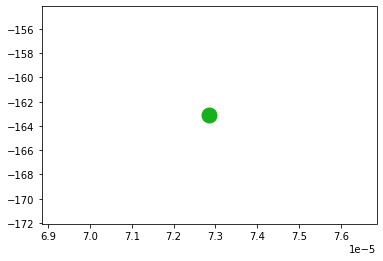

In [34]:
plt.plot(next(x for x in pe if not np.isnan(x)), next(x for x in j0 if not np.isnan(x)), '.', color='xkcd:green', markersize=30)

In [7]:
colors = np.array([[5,113,176,255],
                   [171,229,255,255],
                   [255,240,189,255],
                   [222,130,38,255],
                   [202,0,32,255],
                   [220,22,177,255],
                   [132,17,177,255]])
colors = colors / 255
nodes = (np.array([-500, -300, 100, 500, 1500, 2500, 3500]) + 500) / 4000
mycmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))


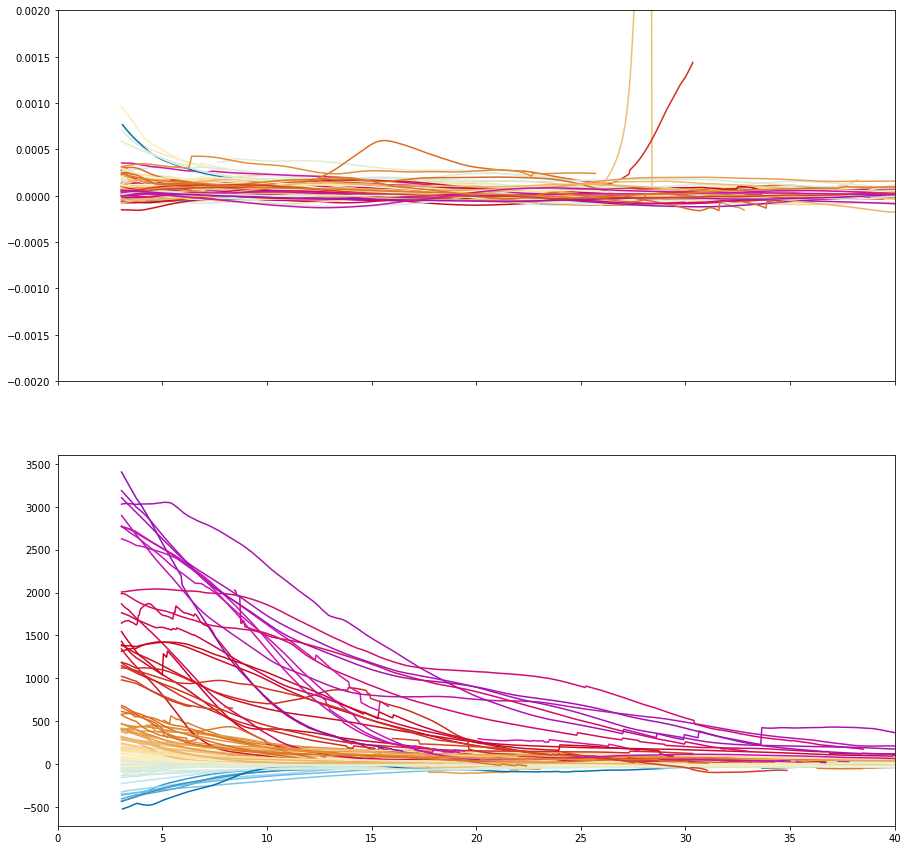

In [7]:
# results

fig, ax1 = plt.subplots(2, 1, sharex=True, figsize=(15, 15))
# cmap = cm.get_cmap('Spectral_r')
for key in mega_results:
    z_max = np.nanmax(mega_results[key]['avg']['udiff_sm'])
    z_min = np.nanmin(mega_results[key]['avg']['udiff_sm'])
    z_value = z_max if abs(z_max) > abs(z_min) else z_min
    z_value_scaled = (z_value + 500) / 4000
    rgba = mycmap(z_value_scaled)
    # if z_value > 1000:
    #     linecolor = 'xkcd:red'
    # elif z_value < -250: 
    #     linecolor = 'xkcd:blue'
    # else:
    #     linecolor = 'xkcd:green'
    # linecolor = (z_value + 500) / 3500
    # linecolor = 1 if linecolor > 1 else linecolor 
    # linecolor = 0 if linecolor < 0 else linecolor 
    # print(key, linecolor)
    ax1[0].plot(mega_results[key]['avg']['d'], mega_results[key]['avg']['pe_ignore_dslope'], color=rgba)    # color=burd(linecolor)
    ax1[0].set_ylim([-0.002, 0.002])
    ax1[1].plot(mega_results[key]['avg']['d'], mega_results[key]['avg']['udiff_sm'], color=rgba)
    ax1[1].set_xlim([0, 40])


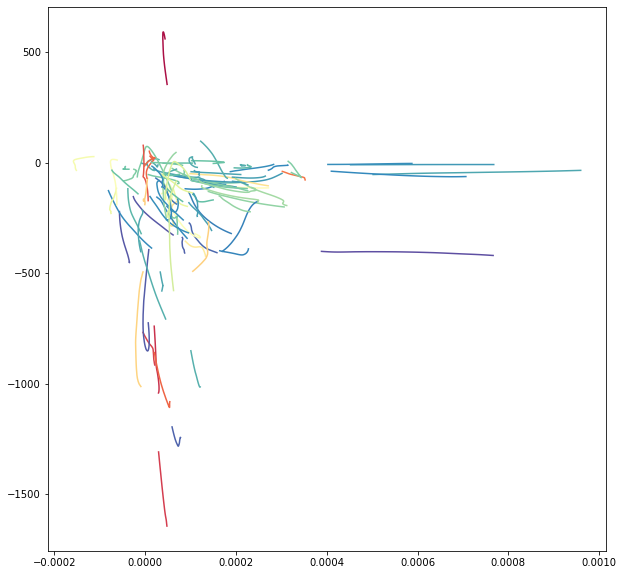

In [8]:
fig, ax2 = plt.subplots(1, 1, sharex=True, figsize=(10, 10))
cmap = cm.get_cmap('Spectral_r')
for key in mega_results:
    z_max = np.nanmax(mega_results[key]['avg']['udiff_sm'])
    z_min = np.nanmin(mega_results[key]['avg']['udiff_sm'])
    z_value = z_max if abs(z_max) > abs(z_min) else z_min
    z_value_scaled = (z_value + 500) / 4000
    rgba = cmap(z_value_scaled)
    # if z_value > 200:
    #     linecolor = 'xkcd:red'
    # elif z_value < -250: 
    #     linecolor = 'xkcd:blue'
    # else:
    #     linecolor = 'xkcd:green'
    # linecolor = (z_value + 500) / 3500
    # linecolor = 1 if linecolor > 1 else linecolor 
    # linecolor = 0 if linecolor < 0 else linecolor 
    # ax2.plot(mega_results[key]['avg']['pe'][:100], mega_results[key]['avg']['j0'][:100], color=linecolor)
    ax2.plot(mega_results[key]['avg']['pe_ignore_dslope'][:100], mega_results[key]['avg']['j0_ignore_dslope'][:100], color=rgba)

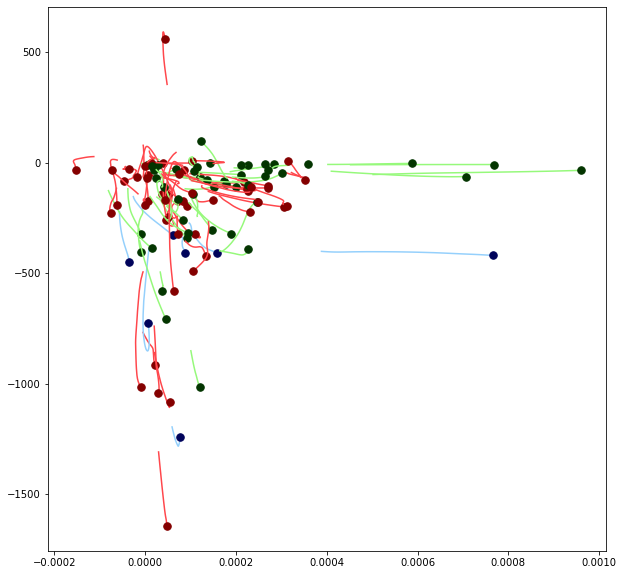

In [8]:
length = 200
fig, ax3 = plt.subplots(1, 1, sharex=True, figsize=(10, 10))
to_df = []
for key in mega_results:
    z_max = np.nanmax(mega_results[key]['avg']['udiff_sm'])
    z_min = np.nanmin(mega_results[key]['avg']['udiff_sm'])
    z_value = z_max if abs(z_max) > abs(z_min) else z_min
    if z_value > 250:
        linecolor1 = 'xkcd:light red'
        linecolor2 = 'xkcd:dark red'
        flag = 'unstable'
    elif z_value < -250: 
        linecolor1 = 'xkcd:light blue'
        linecolor2 = 'xkcd:dark blue'
        flag = 'unstable'
    else:
        linecolor1 = 'xkcd:light green'
        linecolor2 = 'xkcd:dark green'
        flag = 'stable'
    # linecolor = (z_value + 500) / 3500
    # linecolor = 1 if linecolor > 1 else linecolor 
    # linecolor = 0 if linecolor < 0 else linecolor 
    # ax2.plot(mega_results[key]['avg']['pe'][:100], mega_results[key]['avg']['j0'][:100], color=linecolor)
    ax3.plot(mega_results[key]['avg']['pe_ignore_dslope'][:100], mega_results[key]['avg']['j0_ignore_dslope'][:100], color=linecolor1)
    ax3.plot(next(x for x in mega_results[key]['avg']['pe_ignore_dslope'] if not np.isnan(x)),
             next(x for x in mega_results[key]['avg']['j0_ignore_dslope'] if not np.isnan(x)), '.', color=linecolor2, markersize=15)
    to_df.append([next(x for x in mega_results[key]['avg']['pe_ignore_dslope'] if not np.isnan(x)), 
                  next(x for x in mega_results[key]['avg']['j0_ignore_dslope'] if not np.isnan(x)), 
                  next(x for x in mega_results[key]['avg']['udiff_sm'] if not np.isnan(x)),
                  flag])

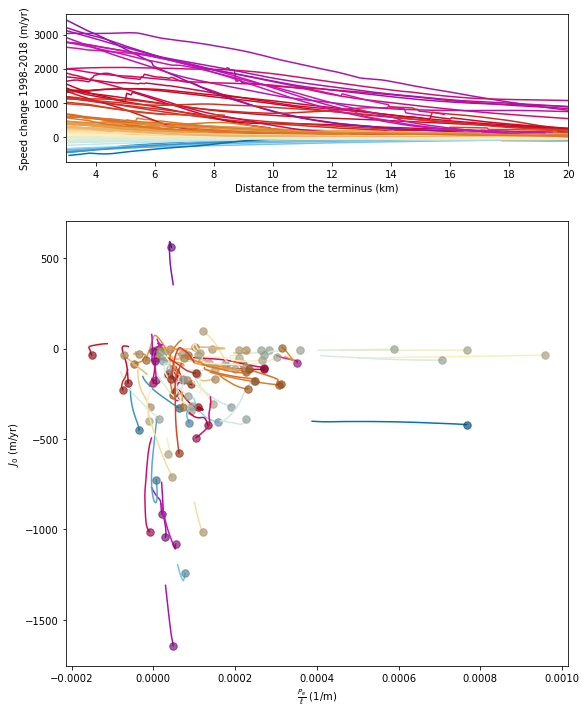

In [34]:
fig, ax4 = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(9, 12))
# fig.tight_layout()
for key in mega_results:
    z_max = np.nanmax(mega_results[key]['avg']['udiff_sm'])
    z_min = np.nanmin(mega_results[key]['avg']['udiff_sm'])
    z_value = z_max if abs(z_max) > abs(z_min) else z_min
    z_value_scaled = (z_value + 500) / 4000
    rgba = mycmap(z_value_scaled)
    rgba2 = np.array(rgba) / 1.5 
    # ax1[0].plot(mega_results[key]['avg']['d'], mega_results[key]['avg']['pe_ignore_dslope'], color=rgba)    # color=burd(linecolor)
    # ax1[0].set_ylim([-0.002, 0.002])
    ax4[0].plot(mega_results[key]['avg']['d'], mega_results[key]['avg']['udiff_sm'], color=rgba)
    ax4[0].set_xlim([3, 20])
    ax4[0].set_xlabel('Distance from the terminus (km)')
    ax4[0].set_ylabel('Speed change 1998-2018 (m/yr)')
    ax4[1].plot(mega_results[key]['avg']['pe_ignore_dslope'][:100], mega_results[key]['avg']['j0_ignore_dslope'][:100], color=rgba)
    ax4[1].plot(next(x for x in mega_results[key]['avg']['pe_ignore_dslope'] if not np.isnan(x)),
                next(x for x in mega_results[key]['avg']['j0_ignore_dslope'] if not np.isnan(x)), '.', color=rgba2, markersize=15)
    ax4[1].set_xlabel(r'$\frac{P_e}{\ell}$ (1/m)')
    ax4[1].set_ylabel(r'$J_0$ (m/yr)')
    
fig.savefig('Fig3.png')

In [9]:
import seaborn as sns
import pandas as pd

In [10]:
df = pd.DataFrame(to_df, columns=[r'$\frac{P_e}{\ell}$ (1/m)', r'$J_0$ (m/yr)', 'Speed diff', 'Class'])
df

,$\frac{P_e}{\ell}$ (1/m),$J_0$ (m/yr),Speed diff,Class
0,0.000021,-915.378881,3029.186179,unstable
1,0.000306,-200.805053,511.123464,unstable
2,-0.000047,-82.857761,456.284207,unstable
3,-0.000034,-450.936824,-435.655180,unstable
4,0.000078,-1243.208582,-349.572187,unstable
...,...,...,...,...
99,0.000234,-112.716518,613.747370,unstable
100,0.000044,-167.859915,1023.168837,unstable
101,0.000054,-1081.388452,2774.927415,unstable
102,0.000315,5.479272,467.138448,unstable


In [11]:
df['Speed diff']

0      3029.186179
1       511.123464
2       456.284207
3      -435.655180
4      -349.572187
          ...     
99      613.747370
100    1023.168837
101    2774.927415
102     467.138448
103     573.128198
Name: Speed diff, Length: 104, dtype: float64

In [42]:
df.to_pickle('tmp.p')

array([[<AxesSubplot:title={'center':'Speed'}>]], dtype=object)

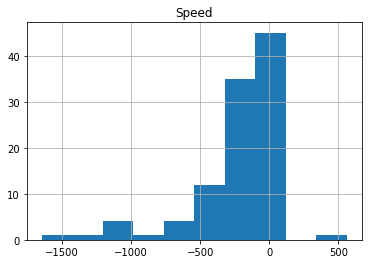

In [38]:
df.hist(column='Speed')

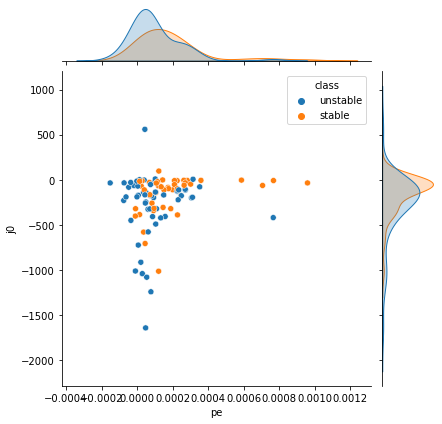

In [13]:
aa = sns.jointplot(data=df, x="pe", y="j0", hue="class")

In [14]:
aa

In [ ]:
mega_results['0001']['avg']['pe_ignore_dslope'][:length]

In [10]:
# for i, j in zip(results['glacier0021.nc']['d'], results['glacier0021.nc']['pe']):
#     print(i, j)

Text(0.5, 1.0, 'Greenland Ice Sheet \n Accelerated glaciers = red; Stable glaciers = blue; Decce. gl. = brown')

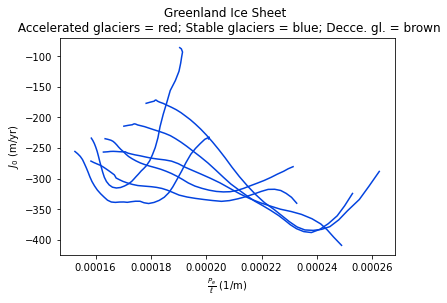

In [12]:
fig, ax3 = plt.subplots(1, 1, sharex=True)
for key in results:
    z_max = np.nanmax(results[key]['udiff_sm'])
    z_min = np.nanmin(results[key]['udiff_sm'])
    z_value = z_max if abs(z_max) > abs(z_min) else z_min
    if z_value > 1000:
        linecolor = 'xkcd:red'
    elif z_value < -250: 
        linecolor = 'xkcd:brown'
    else:
        linecolor = 'xkcd:blue'
    # linecolor = (z_value + 500) / 3500
    # linecolor = 1 if linecolor > 1 else linecolor 
    # linecolor = 0 if linecolor < 0 else linecolor 
    # ax3.plot(results[key]['term1'][:150] + results[key]['term2'][:150] + results[key]['term3'][:150] + results[key]['term4'][:150], results[key]['j0'][:150], color=linecolor)
    ax3.plot(results[key]['term1'][:100] + results[key]['term2'][:100] + results[key]['term3'][:100], results[key]['j0'][:100], color=linecolor)

    
ax3.set_xlabel(r'$\frac{P_e}{\ell}$ (1/m)')
ax3.set_ylabel(r'$J_0$ (m/yr)')
ax3.set_title('Greenland Ice Sheet \n Accelerated glaciers = red; Stable glaciers = blue; Decce. gl. = brown')

In [12]:
# fig, ax4 = plt.subplots(1, 1, sharex=True)
# for key in results:
#     z_max = np.nanmax(results[key]['udiff_sm'])
#     z_min = np.nanmin(results[key]['udiff_sm'])
#     z_value = z_max if abs(z_max) > abs(z_min) else z_min
#     if z_value > 500:
#         linecolor = 'xkcd:red'
#     elif z_value < -250: 
#         linecolor = 'xkcd:brown'
#     else:
#         linecolor = 'xkcd:blue'
#     # linecolor = (z_value + 500) / 3500
#     # linecolor = 1 if linecolor > 1 else linecolor 
#     # linecolor = 0 if linecolor < 0 else linecolor 
#     # ax3.plot(results[key]['term1'][:150] + results[key]['term2'][:150] + results[key]['term3'][:150] + results[key]['term4'][:150], results[key]['j0'][:150], color=burd(linecolor))
#     ax4.plot(results[key]['term1'][:100] + results[key]['term2'][:100] + results[key]['term3'][:100], results[key]['j0'][:100], color=linecolor)

    
# ax4.set_xlabel(r'$\frac{P_e}{\ell}$ (1/m)')
# ax4.set_ylabel(r'$J_0$ (m/yr)')
# ax4.set_title('Greenland Ice Sheet \n Accelerated glaciers = red; Stable glaciers = blue; Decce. gl. = brown')

In [13]:
from pathlib import Path
Path(glacier_file).stem

'glacierd216'